# 0. Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

import re

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import multiprocess as mp

from typing import Dict, List, Any, Tuple, Callable, Union


# 1. Load in the data
## 1.1 Load and Join Labels
This code loads in my bank transactions which consists of a date, amount, description and account balance. Then, if the transaction appears in my labelled dataset, it adds its labelled class with a join. 

A transaction is considered the same if it has the same description and amount to account for the fact that some purchases with the same description are in different classes (e.g. fuel vs. food is differentiated by the amount spent at the petrol station)

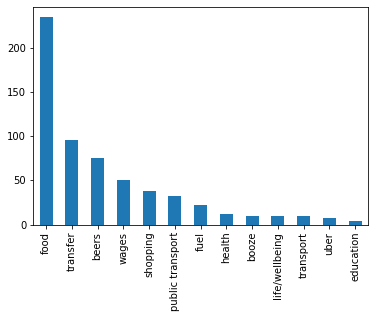

In [2]:
# Set path
path = "../components/private_files/"

# Load in data

data = pd.read_csv(path + "CSVData.csv", header=None)
data.columns = ["date", "amount", "description", "balance"]
data['date']  = pd.to_datetime(data['date'], format='%d/%m/%Y')
data = data.drop("balance", axis=1)
data = data.astype({'amount':'float'})

# Load in labels and join to data

labels = pd.read_csv(path + "transactions_labelled.csv")
labels = labels.drop("date", axis=1)
labels = labels.drop_duplicates()


labels.description = labels.description.str.strip()
labels.description = labels.description.str.lower()
data.description = data.description.str.strip()
data.description = data.description.str.lower()


data_labs = data.merge(labels, on=["description", "amount"], how="left", validate="many_to_one")

data_labs.category.value_counts().plot(kind='bar')


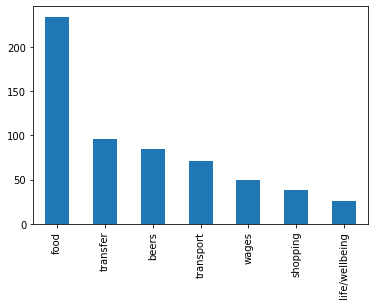

In [3]:
# Merge some of the underrepresented labels

data_labs.category = ["beers" if cat == "entertainment" else cat for cat in data_labs.category]
data_labs.category = ["beers" if cat == "booze" else cat for cat in data_labs.category]
data_labs.category = ["wages" if cat == "tutoring" else cat for cat in data_labs.category]
data_labs.category = ["health" if cat == "education" else cat for cat in data_labs.category]
data_labs.category = ["life/wellbeing" if cat == "health" else cat for cat in data_labs.category]
data_labs.category = ["transfer" if cat == "donation" else cat for cat in data_labs.category]
data_labs.category = ["transport" if cat in ["uber", "public transport", "fuel"] else cat for cat in data_labs.category]

data_labs.reset_index()
data_labs.category.value_counts().plot(kind='bar')


This narrows down the categories to 7:
1. food
2. transfers
3. beers
4. transport
5. wages
6. shopping
7. life/wellbeing

## 1.2 Scrape "Value Date" from Descriptions
Some transactions are not processed immediately at the point of sale. When the bank transaction is finally approved, my bank records this as the date and appends the actual date of the transaction (which may have been up to 5 days in the past, the average I found was a 3 day delay) to the end of the description as "Value Date: dd/mm/YYYY". If the transaction goes through immediately, it just records the current date and leaves the description as is. (At least, this is the process that I inferred. I was unable to find any documentation to confirm this.)

Hence, I had to do a little scraping to collect these value dates when they appeared so that I had the date of the actual transaction.

In [4]:
# Scrape descriptions for "value date" (actual date of transaction)

value_dates = []
for desc in data_labs.description:
    if "value date: " in desc:
        val_date = desc.split("value date: ")[1]
        val_date = val_date.strip()
        value_dates.append(val_date)
    else:
        value_dates.append(None)
value_dates = np.array(value_dates)
data_labs["value_date"] = value_dates
data_labs.value_date = pd.to_datetime(data_labs.value_date, format='%d/%m/%Y')

# If there is no value date in the description, 
# it is assumed that the date of the record is the date of the transaction.

transaction_date = []
for index, row in data_labs.iterrows():
    if pd.isnull(row.value_date):
        transaction_date.append(row.date)
    else:
        transaction_date.append(row.value_date)
        
data_labs["trans_date"] = transaction_date
data_labs.drop("description", axis=1) # Not showing description for privacy reasons


,date,amount,category,value_date,trans_date
0,2020-07-27,50.0,wages,NaT,2020-07-27
1,2020-07-27,-4.8,food,NaT,2020-07-27
2,2020-07-27,-4.0,food,NaT,2020-07-27
3,2020-07-26,50.0,wages,NaT,2020-07-26
4,2020-07-25,-14.5,food,NaT,2020-07-25
...,...,...,...,...,...
595,2019-09-13,-36.0,beers,2019-09-11,2019-09-11
596,2019-09-12,-42.2,food,2019-09-09,2019-09-09
597,2019-09-12,-13.0,beers,2019-09-06,2019-09-06
598,2019-09-12,19.0,food,2019-09-09,2019-09-09


# 2. Feature Extraction

## 2.1 Weekday
Next, I wanted to pull out some interesting features. I figured whether the transaction occurred on a weekend would be telling. Initially I was going to just use a boolean isWeekend column marking when the weekday was 4, 5 or 6 (friday, saturday or sunday), but then I thought to let the models determine a cut off naturally, leaving the weekday as an integer.

In [5]:
tr_data = data_labs.drop(["date", "value_date"], axis=1)
tr_data.columns = ["amount", "description", "category", "date"]
# tr_data["weekend"] = [True if day >= 4 else False for day in tr_data.weekday]
# tr_data = tr_data.drop("weekday", axis=1)
tr_data["weekday"] = tr_data.date.dt.weekday
tr_data.drop("description", axis=1)


,amount,category,date,weekday
0,50.0,wages,2020-07-27,0
1,-4.8,food,2020-07-27,0
2,-4.0,food,2020-07-27,0
3,50.0,wages,2020-07-26,6
4,-14.5,food,2020-07-25,5
...,...,...,...,...
595,-36.0,beers,2019-09-11,2
596,-42.2,food,2019-09-09,0
597,-13.0,beers,2019-09-06,4
598,19.0,food,2019-09-09,0


## 2.2 Natural Language Processing

### 2.2.0 Overview

Bank descriptions are limited to only a few characters. Hence, the text differs to most NLP texts in a few areas:
* Most of the words are meaningful
* Shortened words are common

The general approach I have decided to take to extract features from the descriptions of each transaction is as follows:
1. Clean the descriptions (remove numbers, punctuation, single-letter words, stopwords, repeated words etc.)
2. On the training data, collect a corpus of words for each class. This is a list of words that is loosely indicative of the class itself. A naive approach would be to add all of the unique words that appear in the cleaned descriptions of a given class to that class's corpus. We also add "chopped" versions of each word which will be discussed later.
3. For each entry in the test set, measure how closely its cleaned description resembles the corpus of each class. Create a column for each class that quantitatively represents how close that entry's description is to the corpus of each class.


### 2.2.1 Cleaning The Descriptions

#### Blacklist
Due to the first dot point above, stopwords are not that common. But in the rare case they appear, it wouldn't hurt to filter them out so that's what we do. I also add a few terms to the blacklist that appear commonly at the end of most descriptions and are hence meaningless in terms of class differentiation, e.g. "card", "aus", "ns", etc.


In [6]:
blacklist = stopwords.words('english')
blacklist += ['card', 'aus', 'au', 'ns', 'nsw', 'xx', 'pty', 'ltd', 'nswau']

#### Cleaning
Now that we have defined a blacklist, we can build our cleaning function. Firstly, note that the descriptions have already been converted to lowercase. With this in mind, we go on to remove the "value date" aspect of the description if present. Then we remove all non-alphanumeric characters, replacing them with a space. We then remove all words that are either in the blacklist, are shorter than two letters or that are duplicates of a word that has already passed the checks previously.

In [7]:
def clean(string:str, blacklist:List[str]) -> str:
    features = ""
    out = string
    if "value date: " in out:
        out = out.split("value date: ")[0]
    out = re.sub(r'([^a-z ]+)', " ", out) # remove non-alphabetic characters
    for word in out.strip().split(" "):
        if word not in blacklist and len(word) > 1 and " " + word + " " not in features: # ensuring no duplicates
            features += word + " "
    return features.strip()


Here we use the above function to create a column for the cleaned descriptions, called "desc_features"

In [8]:
tr_data["desc_features"] = [clean(desc, blacklist) for desc in tr_data.description]

### 2.2.2 Collecting Each Class Corpus

#### N-Grams (aka "The Chop")
To address the fact that shortened words are common, I proposed a very naive approach were I essentially "chop up" larger words down to a length of three in the following manner:
If given the word "McDonalds", we would add to our corpus the words "McDonalds", "McDonald", "McDonal", "McDona", "McDon", "McDo", "McD". 

Essentially, this is adding all character n-grams but rooting the starting character.

A convincing reason why this isn't a horrible idea is that my bank appends the "Value Date" to the end of the description, overwriting the description if it becomes too long. This results in words being cut off frequently. 


#### Extracting the Candidates to Build Each Class Corpus
By adding the chopped words along with the words themselves as candidates for each class corpus, we make each corpus invariant to the "value date cutoff" phenomenon. 

We implement this technique in the following function. Similar to the *clean* function above, but adding in the rooted character n-grams, where n>2.

In [9]:
def clean_chop(string:str, blacklist:List[str]) -> str:
    corpus = ""
    out = string
    if "value date: " in out:
        out = out.split("value date: ")[0]
    out = re.sub(r'([^a-z ]+)', " ", out) # remove non-alphabetic characters
    for word in out.strip().split(" "):
        if word not in blacklist and len(word) > 1 and " " + word + " " not in corpus: # ensuring no duplicates
            wrd = word
            while len(wrd) > 2:
                corpus += wrd + " "
                wrd = wrd[0:-1]
    return corpus.strip()

#### Vowel Removal
A limitation to the approach above is that we in no way account for deliberate word shortening i.e. removal of vowels ("rmvl of vwls"). I did try to implement a de-vowel method to maybe account for this, but it actually resulted in diminished performance so I scrapped the idea. 

In [10]:
# def clean_chop_devowel(string):
#     corpus = ""
#     out = string
#     if "value date: " in out:
#         out = out.split("value date: ")[0]
#     out = re.sub(r'([^a-z ]+)', " ", out) # remove non-alphabetic characters
#     out = out.strip().split(" ")
#     for word in out:
#         if word not in blacklist and len(word) > 1 and " " + word + " " not in corpus: # ensuring no duplicates
#             corpus += re.sub(r'([aeiou])+', "", word) + " " # Add devowelled word
#             wrd = word
#             while len(wrd) >= 3:
#                 corpus += wrd + " "
#                 wrd = wrd[0:-1]
#     return corpus.strip()

# def clean_devowel(string):
#     features = ""
#     out = string
#     if "value date: " in out:
#         out = out.split("value date: ")[0]
#     out = re.sub(r'([^a-z ]+)', " ", out) # remove non-alphabetic characters
#     for word in out.strip().split(" "):
#         if word not in blacklist and len(word) > 1 and " " + word + " " not in features: # ensuring no duplicates
#             features += re.sub(r'([aeiou])+', "", word) + " "
#             features += word + " "
#     return features.strip()

#### Collecting Candidates

Here, we implement the function defined above to extract the candidates which we will build our class corpora on. Below, you can see the output for a specific entry involving McDonalds.

In [11]:
tr_data["desc_corpus"] = [clean_chop(desc, blacklist) for desc in tr_data.description]
tr_data.iloc[[1]]


,amount,description,category,date,weekday,desc_features,desc_corpus
1,-4.8,mcdonalds gladesville gladesville nswau,food,2020-07-27,0,mcdonalds gladesville,mcdonalds mcdonald mcdonal mcdona mcdon mcdo m...


#### Creating Each Class Corpus
Here, I define a get_corpus function that will collect the corpus of each class. The idea is to collect a list of words for each class. The list of words will in some way characterise the class. I added a threshold parameter which I can adjust to only count words that appear a certain number of times in a particular class. If the word "panther" appears in only one "food" entry, then its unlikely that a description containing "panther" would generalise to every food item.

In [12]:
def get_corpora(training:pd.DataFrame, min_freq=0) -> Dict[str, List[str]]:
    try:
        assert set(["category", "desc_corpus"]).issubset(set(training.columns))
    except:
        raise InvalidDataFrameFormat(training, message="'category' and/or 'desc_corpus' columns not found. Could not extract corpora from dataframe.")

    global_corpora:Dict[str, List[str]] = {}
    for cat in training.category.unique():
        corpus:Dict[str, int] = {}
        for index, row in training[training.category == cat].iterrows():    # Counting appearances of each corpus candidate within the class
            words = row.desc_corpus.split(" ")
            for word in words:
                if word not in corpus.keys():
                    corpus[word] = 1
                else:
                    corpus[word] += 1
        
        # Order the words in descending frequency
        words = {k: v for k, v in sorted(corpus.items(), key=lambda item: (item[1], 1/len(item[0])), reverse=True)}
        freq = np.array(list(words.values()))
        perc = freq/training[training.category == cat].shape[0]
        features = []
        for word, count in zip(words.keys(), freq):
            if count > min_freq:
                features.append(word)
        global_corpora[cat] = features
    return global_corpora



### 2.2.3 Quantitatively Determine the "Likeness" of Each Description to Each Class Corpus

Now, for each entry, we compare its description features (the description stripped of all numbers and punctuation) to the corpus of each class (found with the function above). Firstly, I take each word in the entry's `desc_features` and compare its similarity to each word in the corpus of a given class (using the jaccard distance because its computationally efficient). It then tries all words in the class corpus and returns the minimum (this will be 0 if it finds an exact match). It does this for all the words in the description features, then takes an average of the minimum distances. This is how I estimate the "closeness" of each description to the class corpus of each class.

We then store each entry's "closeness" to each class in separate columns, one column per class labelled `<class>_desc_dist`

In [13]:
# distance = nltk.edit_distance
def distance(string1:str, string2:str) -> float:
    return nltk.jaccard_distance(set(string1), set(string2))

def desc_dist(corpus:List[str], desc:str, distance:Callable=distance) -> float:
    if len(corpus) == 0:
        return 100.0
    min_distances = []
    for feature in desc.split(" "):
        min_dist = np.inf
        for corp in corpus:                 # Find the minimum distance that each feature has to any corpus item (best possible match)
            dist = distance(feature, corp)
            if dist == 0.0:
                min_dist = dist
                break
            if dist < min_dist:
                min_dist = dist
        min_distances.append(min_dist)
    return np.mean(min_distances)           # Return the mean "best case" distance 


def NLP_distances(dat:pd.DataFrame, corpus:Dict[str, List[str]], desc_dist:Callable=desc_dist) -> pd.DataFrame:
    data=dat.copy()
    try:
        assert set(["description", "date", "desc_features", "desc_corpus"]).issubset(set(data.columns))
    except:
        raise InvalidDataFrameFormat(data, message='Missing some column(s) from the set: {"description", "date", "desc_features", "desc_corpus"}')

    for cat, corp in corpus.items():
        data[cat + "_desc_dist"] = [desc_dist(corp, desc) for desc in data.desc_features]
    data = data.drop(["description", "date", "desc_features", "desc_corpus"], axis=1)
    return data


Using the above functions, we have the full set of features to train our model with:

In [14]:
labelled_data = tr_data[~pd.isnull(tr_data.category)]

labelled_data = NLP_distances(labelled_data, get_corpora(labelled_data))

labelled_data


,amount,category,weekday,wages_desc_dist,food_desc_dist,transfer_desc_dist,life/wellbeing_desc_dist,shopping_desc_dist,transport_desc_dist,beers_desc_dist
0,50.0,wages,0,0.000000,0.427579,0.265741,0.363889,0.451190,0.497024,0.396296
1,-4.8,food,0,0.449495,0.000000,0.422222,0.187500,0.187500,0.187500,0.187500
2,-4.0,food,0,0.449495,0.000000,0.422222,0.187500,0.187500,0.187500,0.187500
3,50.0,wages,6,0.000000,0.339286,0.400000,0.520909,0.492381,0.443810,0.375000
4,-14.5,food,5,0.357143,0.000000,0.342857,0.142857,0.250000,0.272727,0.222222
...,...,...,...,...,...,...,...,...,...,...
595,-36.0,beers,2,0.352273,0.166667,0.500000,0.400000,0.222222,0.500000,0.000000
596,-42.2,food,0,0.350000,0.000000,0.266667,0.200000,0.266667,0.150000,0.111111
597,-13.0,beers,4,0.442857,0.198571,0.355238,0.465714,0.491429,0.313333,0.000000
598,19.0,food,0,0.369643,0.000000,0.200000,0.150000,0.200000,0.154167,0.166667


# 3. Scaling
Some of the models I want to use (e.g. nearest neighbour) will require the data be scaled. Here, I create a function that will take in our scaler (which we will fit on the training data) and scale our dataframe.

In [15]:
def scale(data:pd.DataFrame, scaler:StandardScaler) -> pd.DataFrame:
    norm = scaler.transform(data)
    norm_data = pd.DataFrame(norm, columns = data.columns, index = data.index)
    return norm_data

# 4. Implementing a "Lookup" functionality

If an entry of the test data has the exact same description as some example in the training data, then we can assume it has the same class as the training example.

Firstly, we ensure that we discount any training examples which have the same description but have multiple classes (such as fuel and food for petrol stations). Then we can safely merge the test entries onto the training examples using `desc_features` as the key. The following function implements this, returning an array of predicted classes if found, otherwise NaN if the class wasn't found.

In [16]:
def get_lookup(X_train, X_test):
    table = pd.DataFrame(X_train[["desc_features", "category"]].groupby(["desc_features"])["category"].unique().apply(','.join))
    table = table.reset_index()
    table = table[~table.category.str.contains(",")]
    lookup_predictions = np.array(X_test.drop("category", axis=1).merge(table, on="desc_features", how="left", validate="many_to_one").category, dtype=object)
    return lookup_predictions


# 5. Implementing a "Webscrape" functionality

## 5.1 Scraping Results
The next idea I had to improve the accuracy of my model is to abuse Google's suggestions sidebar. When you google something like a restaurant, most of the time Google will give you a side-bar showcasing the business that it thinks best suits your search query. The side-bar has an html element which gives the business a category. For example, when I google "McDonald Gladesville" (the least creative example I could think of), Google tells me that this is a fast food restaurant. 

<img src="files/google_sidebar_example.png">

Thankfully, it turns out that the class of this HTML element is always labelled "YhemCb", meaning we can easily scrape it with BeautifulSoup, retrieving the HTML element:

`<span class="YhemCb"><span>Fast food restaurant</span></span>`

My experimentation also found that if you google a larger company, similar details are stored in a class labelled "wwUB2c PZPZlf" i.e. when googling "McDonalds" we would want to retrieve this HTML element to get that it is a "Fast food company":

`<div class="wwUB2c PZPZlf" data-attrid="subtitle"><span data-ved="2ahUKEwiZsZLXspLrAhXYeisKHTRvDdoQ2kooAjAcegQIGhAO">Fast food company</span></div>`

A bit of processing, and we can extract the desired text which will go a long way in identifying the transaction's class, in this case "food". The following function from `components/scripts/scraper.py` implements the above:


In [17]:
import requests # type: ignore
from bs4 import BeautifulSoup # type: ignore

def google(query:str, verbose=True) -> str:
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    req = requests.get("https://www.google.com/search?q="+query, headers=headers)
    req.raise_for_status()
    soup = BeautifulSoup(req.text, "html.parser")
    bus = soup.find_all("span", class_="YhemCb")  # potential results for business
    comp = soup.find_all("div", class_="wwUB2c PZPZlf") # potential results for larger company
    if len(bus) > 0:
        bus = str(bus[-1])
        bus = bus.split(">")[1].split("<")[0]
        if " in " in bus:
            bus = bus.split(" in ")[0]
        print("✅ query: " + query, "result: " + bus) if verbose else None
        return bus
    elif len(comp) == 1:
            comp = str(comp[0])
            comp = comp.split("</span>")[0].split(">")[-1]
            print("✅ query: " + query, "result (company): " + comp) if verbose else None
            return comp
    else:
        print("❌ couldn't find: " + query) if verbose else None
        return "-"

## 5.2 Categorising Results
Once we have retrieved all google query results for each description in the test data, we have the job of categorising them into classes. To do this, I identify a few key indicators for each class (transfer and wages have been left out because it is unlikely that a google search would retrieve any information for these classes). For example, if the google result contains "cafe", "bakery" etc, then it's quite clearly food. Below is the method `categorise` which attempts to sort these results into categories.

In [18]:
def categorise(goog:str, verbose=True) -> Union[str, None]:
    shopping = ["market", "store", "shop"]
    food = ["restaurant", "cafe", "bakery", "takeaway", "food", "coffee", "chicken"]
    beers = ["bar", "pub", "hotel"]
    health = ["dentist", "physiotherapist", "drug", "pharmacy", "pharmacist"]
    transport = ["traffic", "parking", "carpark"] # + ["petrol", "gas"]

    if goog == "":
        return np.NaN
    
    goog = goog.lower()

    for feat in health:
        if feat in goog:
            print("✅ categorised " + goog + " as: " + "life/wellbeing") if verbose else None
            return "life/wellbeing"
    for feat in food:
        if feat in goog:
            print("✅ categorised " + goog + " as: " + "food") if verbose else None
            return "food"
    for feat in beers:
        if feat in goog:
            print("✅ categorised " + goog + " as: " + "beers") if verbose else None
            return "beers"
    for feat in transport:
        if feat in goog:
            print("✅ categorised " + goog + " as: " + "transport") if verbose else None
            return "transport"
    for feat in shopping:
        if feat in goog:
            print("✅ categorised " + goog + " as: " + "shopping") if verbose else None
            return "shopping"
    print("❌ " + "couldn't categorise: " + goog) if verbose else None
    return np.NaN

## 5.3 Optimisation and Implementation
Because Google only permits a certain number of google queries from a given IP adress per day, I needed to store my search results so that I didn't have to re-scrape them every time I ran my model (I only really ever had one shot per day to run my model, the second time Google would lock me out).

To do this, I simply stored the search results for each transaction description in `components/files/google.csv`. Then, before I retrieved the google results from the test data the webscraping way, I would check to see if I had googled it previously by joining the training data to the data in the `google.csv` file. Then I would only ever scrape transactions that I hadn't googled previously before appending their results to the same `google.csv` to be used in the future.


In [19]:
def get_webscrape(testing):
    # Join Webscraping
    results = pd.read_csv(path + "google.csv")

    googled = testing.merge(results, how="left", on="desc_features", validate="many_to_one")
    ungoogled = googled[pd.isna(googled.google)]
    if len(ungoogled) > 0:
        # Scrape any descriptions that haven't been googled before.
        ungoogled = ungoogled[["desc_features"]].drop_duplicates()
        ungoogled["google"] = [google(query) for query in ungoogled.desc_features]

        # Record their results in the google.csv file
        ungoogled.to_csv(path + "google.csv", mode = 'a', header = False, index=False)

        # Join webscraping as before
        results = pd.read_csv(path + "google.csv")
        googled = tr_data.merge(results, how="left", on="desc_features", validate="many_to_one")

        # Assert that there is nothing left ungoogled
        assert len(googled[pd.isna(googled.google)]) == 0

    # Categorise 
    google_preds = [categorise(goog, verbose=False) for goog in googled.google]
    return google_preds



# 6. Evaluating the Model

## 6.1 Implementing the Validation Function
The following function evaluates the accuracy of a single fold, having both `web_scrape` and `lookup` as toggleable options, each of which make use of their respective methods defined above.


In [20]:
def run_fold(X:pd.DataFrame, split:Tuple[np.array, np.array], model:Any, web_scrape=False, lookup=False, verbose=True, min_freq=0) -> float:
    train_index, test_index = split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = X_train.category, X_test.category

    # Web Scraping:
    if web_scrape:
        web_predictions = get_webscrape(X_test)
    
    if lookup:
        lookup_predictions = get_lookup(X_train, X_test)
        
    corpus = get_corpora(X_train, min_freq=min_freq)

    X_train = NLP_distances(X_train.drop('category', axis=1), corpus)
    X_test = NLP_distances(X_test.drop('category', axis=1), corpus)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scale(X_train, scaler)
    X_test = scale(X_test, scaler)
    

    model.fit(X_train, y_train)
    model_predictions = model.predict(X_test)
    predictions = model_predictions
    
    if web_scrape or lookup:
        print("model: ", predictions, type(predictions)) if verbose else None
        if web_scrape:
            print("web: ", web_predictions, type(web_predictions)) if verbose else None
            predictions = np.array([web if str(web) != "nan" else mod for web, mod in zip(web_predictions, predictions)])
        if lookup:
            print("lookup: ", lookup_predictions, type(lookup_predictions)) if verbose else None
            predictions = np.array([look if str(look) != 'nan' else pred for look, pred in zip(lookup_predictions, predictions)])
        corrections = np.array([1 if pred!=mod else 0 for pred, mod in zip(predictions, model_predictions)])
        baseline = np.array([1 if str(look) != 'nan' else 0 for look in lookup_predictions])

    if verbose:
        print("predictions: ", predictions)
        print("actual: ", np.array(y_test))
        print("matches: ", predictions == np.array(y_test))

    acc = sum(predictions == y_test)/len(predictions)

    if verbose and (web_scrape or lookup):
        print(f"corrections: {sum(corrections)} of {len(corrections)}")
        print(f"Baseline (just lookup without ML model): {sum(baseline)/len(baseline)}")
    
    print(acc) if verbose else None
    return acc


## 6.2 Performing k-Fold Cross Validation

In [21]:
n_folds = 10

model = DecisionTreeClassifier()

# Remove unknown transactions
X = tr_data[~pd.isnull(tr_data.category)]

splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
folds = list(splitter.split(X.drop("category", axis=1), X.category))

print(f"Performing {n_folds}-fold cross validation")

accuracies = []

upto = 1
for fold in folds:
    print(str(upto) + " of " + str(n_folds))
    accuracies.append(run_fold(X, fold, model, web_scrape=True, lookup=True, verbose=False))
    upto += 1

acc = round(np.mean(accuracies),4)
print(f"Average over {n_folds} folds: {acc}" )

Performing 10-fold cross validation
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
Average over 10 folds: 0.87


## 6.3 Using Multiprocessing for Cross-Validation
We have written the `run_fold` function in this way so that we can easily implement multiprocessing to speed up the evaluation process. The following code achieves a 10-fold cross validation with multiprocessing:

In [22]:
accuracies = []
def record(acc):
    accuracies.append(acc)

pool = mp.Pool(min(mp.cpu_count(), n_folds))
for fold in folds:
    pool.apply_async(run_fold, args=(X, fold, model, True, True, False), callback = record)
pool.close()
pool.join()

acc = round(np.mean(accuracies),4)
print(f"Average over {n_folds} folds: {acc}" )

Average over 10 folds: 0.8717
